# Brain Tumor Classification (CMPS 261 - Spring 2025)

This notebook trains a deep learning model to classify brain MRI scans as either containing a tumor or not. 
The dataset contains `.jpg` images and `.txt` labels. This project focuses on the classification aspect.

## Workflow:
1. Load and clean dataset
2. Build TensorFlow data pipeline
3. Build and train CNN model
4. Evaluate and save model


In [226]:
# Importing all necessary libraries

# Core Python
import os
import random
import collections

# Visualization 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from PIL import Image

# Data Handling & Math
import numpy as np
import pandas as pd

# Machine Learning: TensorFlow & Keras
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.metrics import Precision, Recall

# Machine Learning: Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score

In [227]:
# Additionally we set specific seeds to ensure reproducibility:

os.environ['PYTHONHASHSEED'] = '1'
os.environ['TF_DETERMINISTIC_OPS'] = '1'
random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

## 1. Dataset Preparation

We load and organize the dataset, which consists of brain MRI images and associated label files.
Each label indicates the presence of a tumor (1) or not (0), along with bounding box data — which we ignore for negative samples, per instructor instructions.

### Loading & Understanding our Data:

In [228]:
# Defining paths to image and label folders respectively:
image_dir = './data/images/'
label_dir = './data/labels/'

# Count # of image files
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
num_images = len(image_files)

print(f"Total number of images: {num_images}")

# Count # of text files
image_files = [f for f in os.listdir(label_dir) if f.endswith('.txt')]
num_labels = len(image_files)

print(f"Total number of labels: {num_labels}")

# Check how many images are missing labels
print(f'There are {num_images - num_labels} images missing a label!')

Total number of images: 893
Total number of labels: 878
There are 15 images missing a label!


### Before proceeding this is a basic example of how we can use the label + BBOX info to display the tumor:

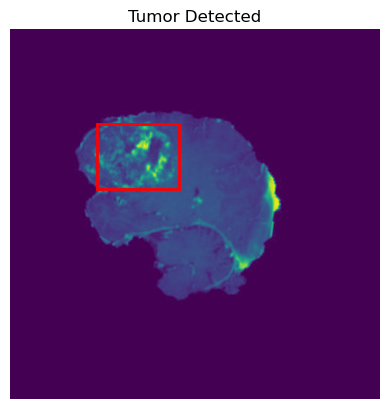

In [229]:
# === Step 1: Load the image ===
image_path = image_dir + '00054_145.jpg'
label_path = label_dir + '00054_145.txt'

image = Image.open(image_path)
img_width, img_height = image.size

# === Step 2: Read the label ===
with open(label_path, 'r') as f:
    line = f.readline().strip()
    parts = line.split()
    label = int(parts[0])
    x_center = float(parts[1])
    y_center = float(parts[2])
    width = float(parts[3])
    height = float(parts[4])

# === Step 3: Convert normalized values to pixels ===
x_center_pixel = x_center * img_width
y_center_pixel = y_center * img_height
box_width_pixel = width * img_width
box_height_pixel = height * img_height

# Convert from center to top-left corner
x_min = x_center_pixel - (box_width_pixel / 2)
y_min = y_center_pixel - (box_height_pixel / 2)

# === Step 4: Plot image and box ===
fig, ax = plt.subplots(1)
ax.imshow(image)

# Only draw the box if there's a tumor
if label == 1:
    rect = patches.Rectangle(
        (x_min, y_min),
        box_width_pixel,
        box_height_pixel,
        linewidth=2,
        edgecolor='r',
        facecolor='none'
    )
    ax.add_patch(rect)
    plt.title("Tumor Detected")
else:
    plt.title("No Tumor")

plt.axis('off')
plt.show()

### Okay, now that we understand how the data can be used let's find how many usable pairs we have:

In [230]:
# Helper: get filenames without extension
image_files = set(f[:-4] for f in os.listdir(image_dir) if f.endswith('.jpg'))
label_files = set(f[:-4] for f in os.listdir(label_dir) if f.endswith('.txt'))

# Intersection → only matched pairs
valid_ids = sorted(image_files & label_files)
print(f"Total valid image-label pairs: {len(valid_ids)}")

# Final dataset list
dataset = []

for img_id in valid_ids:
    label_path = os.path.join(label_dir, img_id + '.txt')
    image_path = os.path.join(image_dir, img_id + '.jpg')
    
    with open(label_path, 'r') as f:
        parts = f.readline().strip().split()
        label = int(parts[0])

        if label == 0:
            # No tumor: ignore bbox
            dataset.append((image_path, label, None))
        else:
            # Tumor: include bbox
            bbox = list(map(float, parts[1:]))
            dataset.append((image_path, label, bbox))

print(f"Prepared dataset with {len(dataset)} usable samples")

Total valid image-label pairs: 878
Prepared dataset with 878 usable samples


### Additionally we check for class imbalance within the dataset:

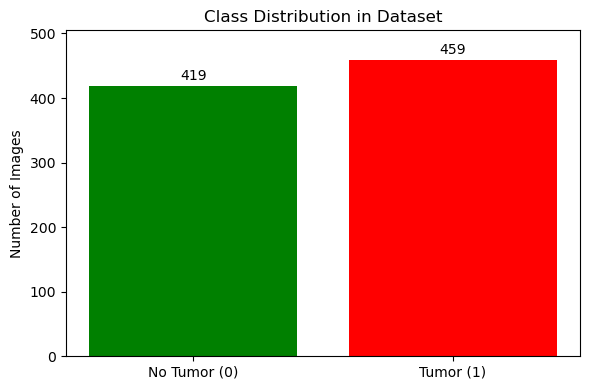

In [231]:
# Checking for class imbalance
label_counts = collections.Counter([label for _, label, _ in dataset])

labels = ['No Tumor (0)', 'Tumor (1)']
counts = [label_counts[0], label_counts[1]]

plt.figure(figsize=(6, 4))
bars = plt.bar(labels, counts, color=['green', 'red'])
plt.title("Class Distribution in Dataset")
plt.ylabel("Number of Images")

# Add count labels on top of each bar
for bar, count in zip(bars, counts):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 5,  # position
             str(count), ha='center', va='bottom', fontsize=10)

plt.ylim(0, max(counts) * 1.1)  # add space above bars
plt.tight_layout()
plt.show()

### The dataset has a fairly balanced distribution. However, we still consider evaluation metrics like precision and recall since we're working with medical data.

## 2. Data Pipeline with `tf.data`

Now that we've bundled our pairs we can create a TensorFlow data pipeline to efficiently load, process, and batch images for training.
This includes:
- Reading image files
- Resizing and normalizing
- Batching and prefetching for performance

### We start by defining general settings and image processing:

In [ ]:
# === General Settings ===
IMG_SIZE = (224, 224)       # Target image dimensions (height, width)
BATCH_SIZE = 32             # Number of samples per training batch

# === Step 1: Image Preprocessing Function ===
def load_and_preprocess(image_path, label, bbox):
    """Load, decode, and preprocess an image and its label.
    Args:
        image_path: Path to the image file (tf.string).
        label: Class label (0 = no tumor, 1 = tumor).
        bbox: Bounding box coordinates (ignored in this function).
    Returns:
        Tuple of (normalized image tensor, label).
    """
    # Read and decode the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Ensure RGB format
    image = tf.image.resize(image, IMG_SIZE)         # Resize to target dimensions
    image = tf.cast(image, tf.float32) / 255.0       # Normalize pixel values to [0, 1]
    return image, label # I'm ignoring bbox for now!

### Now we define a reusable function that creates datasets from a list of image-label-bbox tuples:

In [233]:
# === Step 2: Creating Generalized Dataset Generator ===
def create_dataset(data_list, repeat=True, shuffle=True, name=None):
    """
    Creates a tf.data.Dataset from a list of (image_path, label, bbox) tuples.

    Args:
        data_list (list): List of (image_path, label, bbox) tuples.
        repeat (bool): Whether to repeat the dataset (default: True).
        shuffle (bool): Whether to shuffle the dataset (default: True).

    Returns:
        tf.data.Dataset: A prepared dataset ready for training or evaluation.
    """
    def generator():
        for image_path, label, bbox in data_list:
            # For negative samples (label == 0), supply a dummy bbox
            if bbox is None:
                bbox = [0.0, 0.0, 0.0, 0.0]
            yield image_path.encode(), label, bbox  # Encode path as bytes for TensorFlow

    # Define the output signature (same for all datasets)
    output_signature = (
        tf.TensorSpec(shape=(), dtype=tf.string),   # image_path (scalar string)
        tf.TensorSpec(shape=(), dtype=tf.int32),    # label (scalar integer)
        tf.TensorSpec(shape=(4,), dtype=tf.float32) # bbox (4 float values: x_center, y_center, width, height)
    )

    ds = tf.data.Dataset.from_generator(generator, output_signature=output_signature)
    ds = ds.map(load_and_preprocess)

    if shuffle:
        ds = ds.shuffle(1000)  # Shuffle with buffer size of 1000
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)  # Optimize loading + training overlap
    if repeat:
        ds = ds.repeat()  # Repeat for multiple epochs (if training)

    if name:
        print(f"✅ {name} created successfully.")
    else:
        print("✅ Dataset created successfully.")

    return ds

### Finally we create our first dataset: base_dataset

In [234]:
# Create a dataset using the new create_dataset() function
base_dataset = create_dataset(dataset, name="base_dataset")

✅ base_dataset created successfully.


### Quick test to ensure the dataset yields and displays samples correctly:

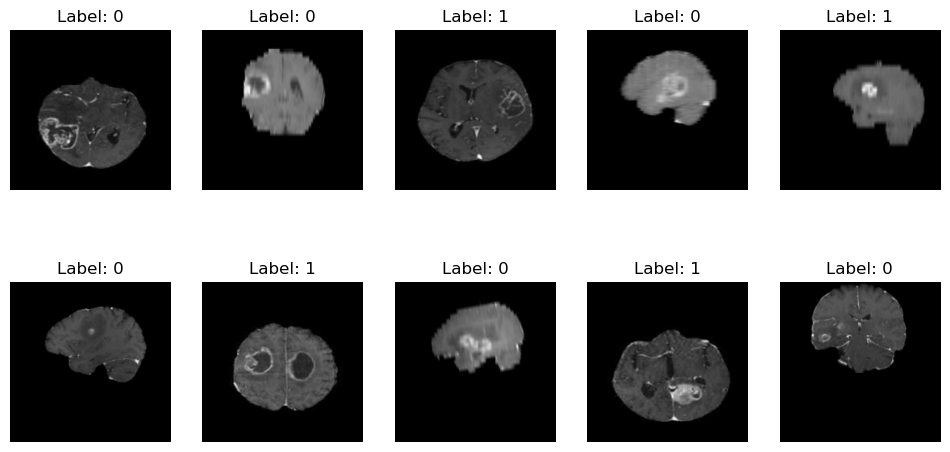

In [235]:
for images, labels in base_dataset.take(1):
    plt.figure(figsize=(12, 6))
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")
    plt.show()

### ✅ Dataset pipeline functional.

## 3. Model Architecture (Transfer Learning)

We use MobileNetV2 as a pretrained CNN backbone, removing its top classification layers.
A custom head is added for binary classification (tumor vs. no tumor), using:
- Global average pooling
- Dense layers
- Dropout for regularization

### Load pretrained model:

In [236]:
# === Load Pretrained MobileNetV2 (without top classifier) ===
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,       # Exclude the original classification head
    weights='imagenet'       # Load pretrained weights from ImageNet
)
base_model.trainable = False  # Freeze the base

# === Add Custom Classification Head ===
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),           # Reduce feature maps to a vector
    layers.Dense(128, activation='relu'),      # Optional fully connected layer
    layers.Dropout(0.3),                       # Regularization
    layers.Dense(1, activation='sigmoid')      # Output layer for binary classification
])

### Compile Model:

In [237]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)


In [238]:
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_10     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### Train Model:

We train the model on the preprocessed dataset using 10 epochs.
The dataset is repeated to support multiple epochs, and steps per epoch are calculated based on batch size.

In [239]:
EPOCHS = 10
steps_per_epoch = len(dataset) // BATCH_SIZE

history = model.fit(
    base_dataset,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch
)

Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 248ms/step - accuracy: 0.5201 - loss: 0.9142 - precision_8: 0.5484 - recall_8: 0.5438
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 249ms/step - accuracy: 0.6423 - loss: 0.6336 - precision_8: 0.6560 - recall_8: 0.6548
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 244ms/step - accuracy: 0.6938 - loss: 0.5763 - precision_8: 0.6978 - recall_8: 0.7149
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 236ms/step - accuracy: 0.7429 - loss: 0.5573 - precision_8: 0.7188 - recall_8: 0.8117
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 240ms/step - accuracy: 0.7321 - loss: 0.5395 - precision_8: 0.7296 - recall_8: 0.7992
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 243ms/step - accuracy: 0.7256 - loss: 0.5079 - precision_8: 0.7075 - recall_8: 0.7734
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 244ms/step - accuracy: 0.7477 - loss: 0.4879 - precision_8: 0.7769 - recall_8: 0.7481
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 242ms/step - accuracy: 0.7772 - loss: 0.4425 - precision_8: 0.7896 - 

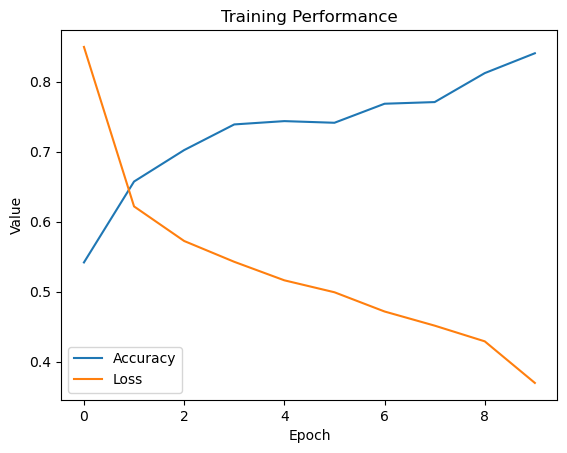

In [240]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['loss'], label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.title('Training Performance')
plt.show()

## 4. Model Evaluation & Saving

We evaluate model performance on a held-out 20% validation set using accuracy and loss metrics.
This helps confirm generalization and detect overfitting.


In [241]:
# Split the original list of tuples (image_path, label, bbox)
train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=1)

print(f"Train size: {len(train_data)}")
print(f"Validation size: {len(val_data)}")

Train size: 702
Validation size: 176


In [242]:
# After splitting the data into train_data and val_data

# We use the already defined create_dataset function to create a train_dataset.
train_dataset = create_dataset(train_data, name="train_dataset")

# Proceed to model training
steps_per_epoch = len(train_data) // BATCH_SIZE
model.fit(train_dataset, epochs=10, steps_per_epoch=steps_per_epoch)

✅ train_dataset created successfully.
Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 255ms/step - accuracy: 0.8388 - loss: 0.3623 - precision_8: 0.8247 - recall_8: 0.8852
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 254ms/step - accuracy: 0.8568 - loss: 0.3359 - precision_8: 0.8638 - recall_8: 0.8582
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 248ms/step - accuracy: 0.8422 - loss: 0.3514 - precision_8: 0.8195 - recall_8: 0.8900
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 248ms/step - accuracy: 0.8740 - loss: 0.3119 - precision_8: 0.8807 - recall_8: 0.8785
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 253ms/step - accuracy: 0.8405 - loss: 0.3285 - precision_8: 0.8038 - recall_8: 0.8943
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 249ms/step - accuracy: 0.8794 - loss: 0.3119 - precision_8: 0.8983 - recall_8: 0.8555
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 252ms/step - accuracy: 0.8913 - loss: 0.2706 - precision_8: 0.8651 - recall_8: 0.9125
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 247ms/step - accuracy: 0.9256 - 

In [243]:
# Same thing we use create_dataset to create the validation set.
val_dataset = create_dataset(val_data, repeat=False, shuffle=False, name="val_dataset")

✅ val_dataset created successfully.


### Now we evaluate using Accuracy, Precision, and Recall

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step - accuracy: 0.9025 - loss: 0.2911 - precision_8: 0.9486 - recall_8: 0.8821


C:\Users\ADMIN\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


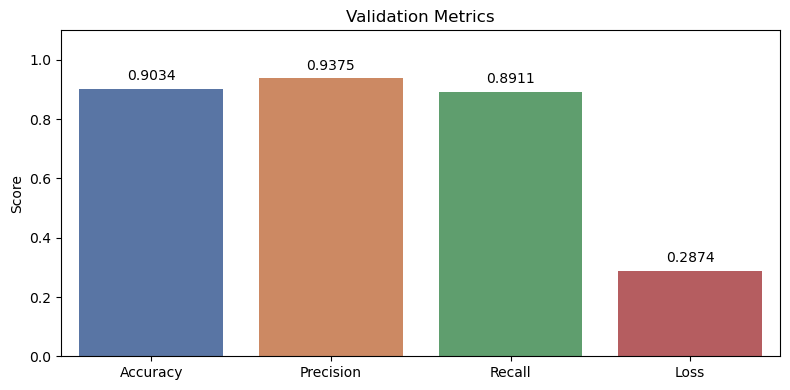

In [244]:
# Evaluate model
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(val_dataset)

# Create DataFrame
metrics_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "Loss"],
    "Value": [val_accuracy, val_precision, val_recall, val_loss]
})

# Plot using seaborn
plt.figure(figsize=(8, 4))
sns.barplot(x="Metric", y="Value", hue="Metric", data=metrics_df, palette="deep", legend=False)

# Add values on top of bars
for index, row in metrics_df.iterrows():
    plt.text(index, row.Value + 0.02, f"{row.Value:.4f}", ha='center', va='bottom', fontsize=10)

plt.ylim(0, 1.1)
plt.title("Validation Metrics")
plt.ylabel("Score")
plt.xlabel("")
plt.tight_layout()
plt.show()

### Let's pause for a second and discuss the metrics:

The graph shows that while our model performs well overall, **recall can still be improved**.

In medical imaging, particularly for tumor detection, recall is a priority — we want to minimize the risk of missing actual tumors.

One effective way to improve recall (and control the balance between metrics) is to adjust the classification threshold. In the next steps, we’ll explore how different thresholds affect accuracy, precision, and recall.


### The following cells explore how adjusting the classification threshold can affect evaluation metrics like accuracy, precision, and recall.

### First we generate the predicted probabilities and extract the true labels for all validation images.


In [245]:
# Extract true labels and predicted probabilities
y_true = [label for _, label, _ in val_data]
y_pred_probs = []

for image_path, label, bbox in val_data:
    # We use existing load_and_preprocess function
    image_tensor, _ = load_and_preprocess(image_path.encode(), label, bbox)
    image_tensor = tf.expand_dims(image_tensor, 0)  # Add batch dimension

    # Predict
    pred = model.predict(image_tensor, verbose=0)[0][0] # We add verbose to supress all the progress bars!
    y_pred_probs.append(pred)

y_pred_probs = np.array(y_pred_probs)
y_true = np.array(y_true)

### Then we evaluate how accuracy, precision, and recall change across different classification thresholds and visualize the results.


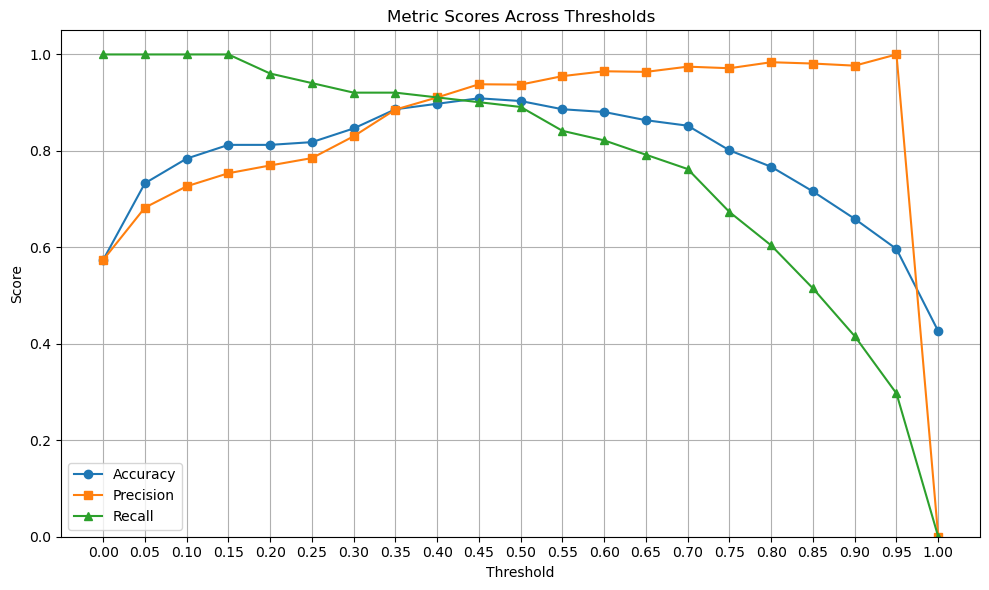

In [246]:
thresholds = np.arange(0, 1.01, 0.05)

accuracies = []
precisions = []
recalls = []

for thresh in thresholds:
    y_pred = (y_pred_probs >= thresh).astype(int)
    accuracies.append(accuracy_score(y_true, y_pred))
    precisions.append(precision_score(y_true, y_pred, zero_division=0))
    recalls.append(recall_score(y_true, y_pred))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(thresholds, accuracies, label="Accuracy", marker='o')
plt.plot(thresholds, precisions, label="Precision", marker='s')
plt.plot(thresholds, recalls, label="Recall", marker='^')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Metric Scores Across Thresholds")
plt.legend()
plt.grid(True)
plt.xticks(np.arange(0, 1.05, 0.05))
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()


### From the above graph we find that a threshold of 0.4 gives us the best balance of the three measures.

In [247]:
threshold = 0.40  # We can adjust this to see different scores.
y_pred = (y_pred_probs >= threshold).astype(int)

# Print metrics
print(f"Threshold: {threshold}")
print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall:    {recall_score(y_true, y_pred):.4f}")

Threshold: 0.4
Accuracy:  0.8977
Precision: 0.9109
Recall:    0.9109


### By adjusting the threshold to 0.4 we were able to achieve a new recall of ***~0.91*** roughly 2% higher than before adjusting. This may seem slight but is quite literally life saving.

### Save the Trained Model

The model is saved as a `.keras` file, preserving both the architecture and weights.
This allows future reuse for inference or deployment.

In [248]:
model.save("brain_tumor_model.keras")

## 5. Predict Tumor Presence on Sample MRI Images

We randomly select images from the validation set and display the model's predictions.
This serves as a qualitative check of model performance.

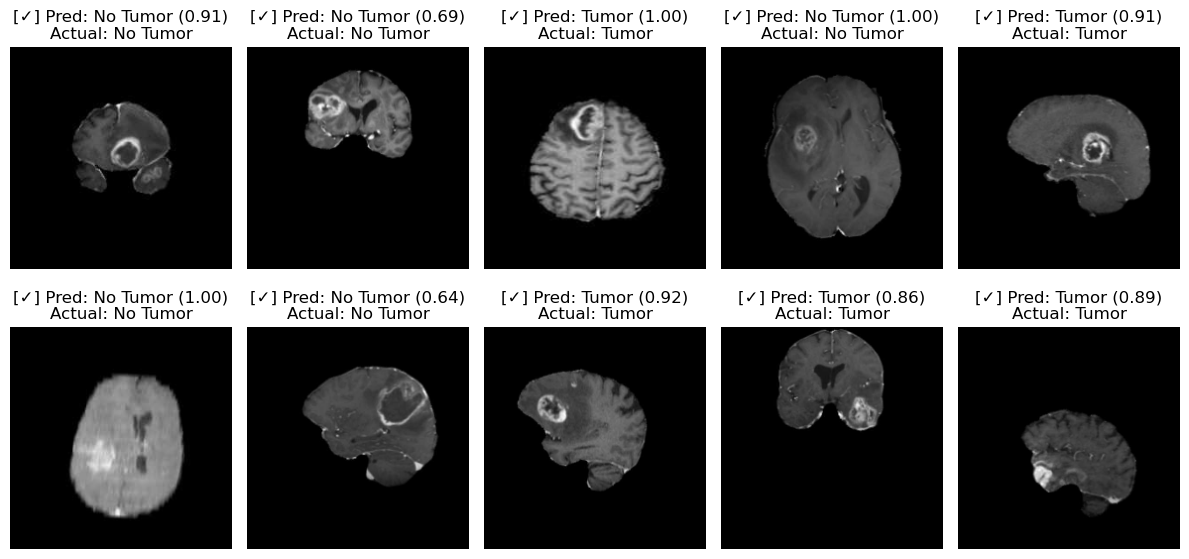

In [250]:
# Choose 10 random samples from validation data
sample_images = random.sample(val_data, 10)

plt.figure(figsize=(12, 6))

for i, (image_path, true_label, bbox) in enumerate(sample_images):
    # Load and preprocess image
    image_raw = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image_raw, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.expand_dims(image, 0)  # Batch dimension

    # Predict
    pred = model.predict(image, verbose=0)[0][0] # Same idea: We add verbose to supress all progress bars.
    pred_label = "Tumor" if pred >= threshold else "No Tumor"
    confidence = pred if pred >= threshold else 1 - pred

    # Ground truth
    actual_label = "Tumor" if true_label == 1 else "No Tumor"

    # Compare actual vs predicted
    is_correct = pred_label == actual_label
    icon = "[✓]" if is_correct else "[X]"


    # Plot
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(tf.squeeze(image))
    plt.title(f"{icon} Pred: {pred_label} ({confidence:.2f})\nActual: {actual_label}")
    plt.axis("off")

plt.tight_layout()
plt.show()